## ... playpen..


### imports etc

In [1]:
# imports
import pandas as pd
import numpy as np
from scipy import stats

import collections
import sklearn
from sklearn import preprocessing as pp

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import interactive
interactive(True)

import sys
import tensorflow as tf
import time
import os
import os.path
import pickle
import pyfolio as pf
import quandl

import logging as log
log.basicConfig(level=log.DEBUG,format='%(asctime)s %(name)s (%(levelname)s): %(message)s')

# load simple trading simulator
#import sim 
#import tf_models

In [2]:
#execfile('sim_fut.py')

quandl.ApiConfig.api_key = os.environ['QUANDL_AUTH']

### pull data

In [3]:
SP_FUTS_QCODE  = 'CHRIS/CME_ES'   # s&p futures
VIX_FUTS_QCODE = 'CHRIS/CBOE_VX'  # volatility futures
GC_FUTS_QCODE  = 'CHRIS/CME_GC'   # gold futures
CL_FUTS_QCODE  = 'CHRIS/CME_CL'   # crude futures
TU_FUTS_QCODE  = 'CHRIS/CME_TU'   # two-year futures
TY_FUTS_QCODE  = 'CHRIS/CME_TY'   # ten-year futures
VIX_QCODE      = 'CBOE/VIX'       # vix index 
VVIX_QCODE     = 'CBOE/VVIX'      # vvix index
VXV_QCODE      = 'CBOE/VXV'       # vxv index
SPY_QCODE      = 'GOOG/NYSE_SPY'  # SPY ETF

In [4]:
sp1 = quandl.get(SP_FUTS_QCODE+'1')
vx2 = quandl.get(VIX_FUTS_QCODE+'2')
gc1 = quandl.get(GC_FUTS_QCODE+'1')
cl1 = quandl.get(CL_FUTS_QCODE+'1')
tu1 = quandl.get(TU_FUTS_QCODE+'1')
ty1 = quandl.get(TY_FUTS_QCODE+'1')
vix = quandl.get(VIX_QCODE)
vvix = quandl.get(VVIX_QCODE)
vxv = quandl.get(VXV_QCODE)
spy = quandl.get(SPY_QCODE)


### visualize prices

,Open,High,Low,Last,Change,Settle,Volume,Open Interest
Date,,,,,,,,
1997-09-09,934.0,942.0,933.0,934.0,NaN,934.0,7034.0,1109.0
1997-09-10,934.0,935.0,915.0,915.0,NaN,915.0,11387.0,2325.0
1997-09-11,916.0,918.0,900.0,908.0,NaN,908.0,2523.0,2549.0
1997-09-12,908.0,926.0,904.0,924.0,NaN,924.0,928.0,2163.0
1997-09-15,925.0,930.0,920.0,922.0,NaN,922.0,208.0,2107.0


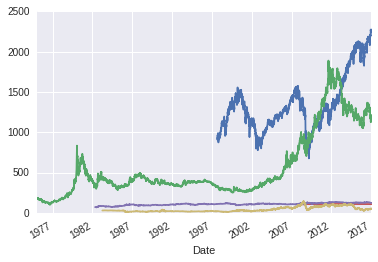

In [5]:
%matplotlib inline 
#%matplotlib notebook
sp1.Settle.plot()
gc1.Settle.plot()
tu1.Settle.plot()
ty1.Settle.plot()
cl1.Settle.plot()
sp1.head()

### calculate returns & navs, scale and revisualize

In [6]:

Returns = pd.DataFrame( {'es':np.log( sp1.Settle/sp1.Settle.shift() ),
                         'tu':np.log(tu1.Settle/tu1.Settle.shift() ),
                         'ty':np.log(ty1.Settle/ty1.Settle.shift() ),
                         #'cl':np.log(cl1.Settle/cl1.Settle.shift() ),
                         'gc':np.log(gc1.Settle/gc1.Settle.shift() ) })
Returns = Returns[Returns.index>'2008-01-01']

print Returns.describe()
print Returns.head()
print tu1.head()
print ty1.head()

                es           gc           tu           ty
count  2313.000000  2264.000000  2258.000000  2277.000000
mean      0.000184     0.000163     0.000014     0.000044
std       0.013566     0.012545     0.000933     0.004157
min      -0.104003    -0.098206    -0.009252    -0.026267
25%      -0.004543    -0.005620    -0.000285    -0.002200
50%       0.000727     0.000233     0.000000     0.000125
75%       0.005682     0.006748     0.000355     0.002386
max       0.132022     0.086250     0.007809     0.035369
                  es        gc        tu        ty
Date                                              
2008-01-02 -0.012774  0.025914  0.004825  0.008780
2008-01-03  0.000171  0.010526  0.000814 -0.000410
2008-01-04 -0.024813 -0.003920  0.001922  0.005587
2008-01-07 -0.001055 -0.004283 -0.000739  0.001494
2008-01-08 -0.017386  0.021007  0.000000  0.000000
                  Open        High         Low        Last  Change  \
Date                                               

es    0.215303
gc    0.199109
tu    0.014814
ty    0.065971
dtype: float64
es     4.644627
gc     5.022365
tu    67.501757
ty    15.158210
dtype: float64


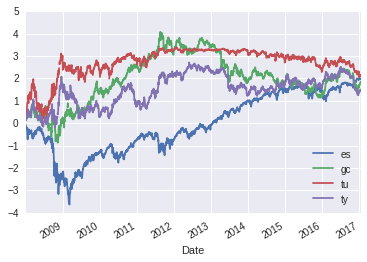

In [15]:
SD = np.sqrt(252) * Returns.apply(np.std ,0)
print SD
R = Returns.apply(np.mean ,0)

#SD.plot.bar()
#R.plot.bar()

# let's normalize everyone to 1 sigma and plot
M = 1/SD 
print M
RS = Returns * M

pd.DataFrame(np.cumsum(RS)).plot()

Date
2008-01-02    3.422750e-03
2008-01-03    5.573238e-06
2008-01-04   -9.862278e-08
2008-01-07    7.180198e-11
2008-01-08   -1.097481e-12
2008-01-09   -1.626388e-14
2008-01-10   -3.220229e-17
2008-01-11    4.800446e-20
2008-01-14    4.878096e-22
2008-01-15   -8.459158e-24
2008-01-16    9.380221e-26
2008-01-17   -2.000889e-27
2008-01-18    1.656415e-29
2008-01-21             NaN
2008-01-22    7.921596e-31
2008-01-23    2.254595e-32
2008-01-24   -1.593036e-34
2008-01-25    1.485659e-36
2008-01-28    2.493132e-38
2008-01-29    2.930103e-42
2008-01-30   -3.987763e-44
2008-01-31   -1.175784e-45
2008-02-01   -1.796096e-47
2008-02-04    2.665716e-49
2008-02-05   -5.609893e-51
2008-02-06    5.474867e-53
2008-02-07    5.922847e-56
2008-02-08   -2.153750e-59
2008-02-11   -1.966045e-61
2008-02-12   -5.287197e-64
                  ...     
2016-12-02    0.000000e+00
2016-12-05    0.000000e+00
2016-12-06    0.000000e+00
2016-12-07    0.000000e+00
2016-12-08    0.000000e+00
2016-12-09    0.000000e

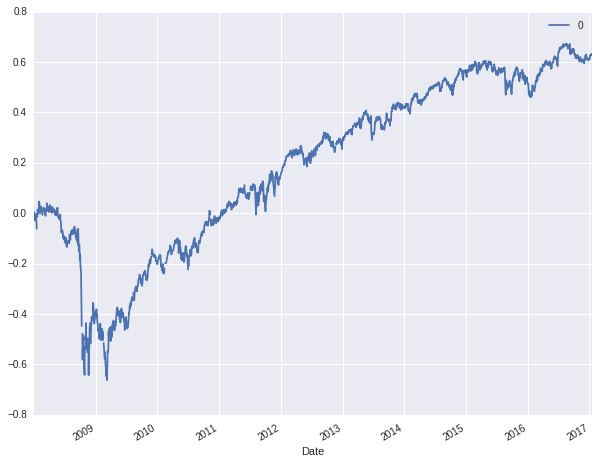

In [16]:
Returns.head()

s1 =  ( 1.0 * Returns.es) + ( 0.1 * Returns.gc ) + (1 * Returns.tu ) + (1* Returns.ty)
pd.DataFrame(np.cumsum(s1)).plot(figsize=[10,8])

